# Translate dates from human to machine format with attention mechanism

This notebook is based on the programming assignment "Neural machine translation" of deeplearning.ai, course Sequence models, week Sequence models and Attention mechanism. The figures are also taken from that assignment.

We will build a model to translate human readable dates ("25th of June, 2009") into machine readable dates ("2009-06-25") using the attention mechanism.

If we had to translate a book's paragraph from French to English, we would not read the whole paragraph, then close the book and translate. Even during the translation process, we would read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English you are writing down. 

The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 

## Learning objectives

- Use of unidirectional and bidirectional LSTM neural network architecture in TensorFlow
- Applying the concept of "reuse" for variables in TensorFlow
- Use Adam optimizer with decay rate
- Use of GPU for the training of the model

In [2]:
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import time

import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
print(tf.__version__)

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

1.14.0


In [3]:
import warnings

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


## Translating human readable dates into machine readable dates


The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*) and translate them into standardized, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD. 



In [4]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 22194.22it/s]


In [5]:
dataset[7800:7850]

[('tuesday july 24 1979', '1979-07-24'),
 ('3 feb 1976', '1976-02-03'),
 ('20.07.06', '2006-07-20'),
 ('26 08 79', '1979-08-26'),
 ('11 nov 2013', '2013-11-11'),
 ('3 mar 2000', '2000-03-03'),
 ('28 nov 1990', '1990-11-28'),
 ('27 jun 2016', '2016-06-27'),
 ('12 feb 1998', '1998-02-12'),
 ('2 march 1992', '1992-03-02'),
 ('24 april 2003', '2003-04-24'),
 ('30.03.87', '1987-03-30'),
 ('monday september 4 1989', '1989-09-04'),
 ('august 12 2006', '2006-08-12'),
 ('9 jul 1980', '1980-07-09'),
 ('8/29/02', '2002-08-29'),
 ('26 dec 2000', '2000-12-26'),
 ('saturday january 30 1971', '1971-01-30'),
 ('25 09 91', '1991-09-25'),
 ('august 24 2005', '2005-08-24'),
 ('tuesday january 6 1987', '1987-01-06'),
 ('friday august 19 1983', '1983-08-19'),
 ('monday march 4 2013', '2013-03-04'),
 ('08 may 2018', '2018-05-08'),
 ('saturday may 15 1999', '1999-05-15'),
 ('2 february 1977', '1977-02-02'),
 ('monday october 15 1984', '1984-10-15'),
 ('thursday may 3 2018', '2018-05-03'),
 ('friday november 

In [6]:
human_vocab

{' ': 0,
 '.': 1,
 '/': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 '<pad>': 36,
 '<unk>': 35,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'y': 34}

In [7]:
human_vocab['<pad>']=-1

In [8]:
human_vocab

{' ': 0,
 '.': 1,
 '/': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 '<pad>': -1,
 '<unk>': 35,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'y': 34}

In [9]:
machine_vocab

{'-': 0,
 '0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}

In [10]:
inv_machine_vocab

{0: '-',
 1: '0',
 2: '1',
 3: '2',
 4: '3',
 5: '4',
 6: '5',
 7: '6',
 8: '7',
 9: '8',
 10: '9'}

We loaded:

- `dataset`: a list of tuples of (human readable date, machine readable date)
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index 
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index. These indices are not necessarily consistent with `human_vocab`. 
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters. 

Let's preprocess the data and map the raw text data into the index values. We will also use Tx=30 (which we assume is the maximum length of the human readable date; if we get a longer input, we would have to truncate it) and Ty=10 (since "YYYY-MM-DD" is 10 characters long). 

In [11]:
def preprocess_data_vmg(dataset, human_vocab, machine_vocab, Tx, Ty):
    
    X, Y = zip(*dataset)
    
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]

    return X, np.array(Y)

In [12]:
Tx = 30
Ty = 10
X, Y = preprocess_data_vmg(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)


We now have:
- `X`: a processed version of the human readable dates in the training set, where each character is replaced by an index mapped to the character via `human_vocab`. Each date is further padded to $T_x$ values with a special character (< pad >). `X.shape = (m, Tx)`
- `Y`: a processed version of the machine readable dates in the training set, where each character is replaced by the index it is mapped to in `machine_vocab`. You should have `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`, the "1" entry's index is mapped to the character thanks to `human_vocab`. `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`, the "1" entry's index is mapped to the character thanks to `machine_vocab`. `Yoh.shape = (m, Tx, len(machine_vocab))`. Here, `len(machine_vocab) = 11` since there are 11 characters ('-' as well as 0-9). 


In [13]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]



## Network architecture and Attention mechanism

The diagram on the left shows the attention model. The diagram on the right shows what one "Attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$, which are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). 

<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> Neural machine translation with attention</center></caption>

In [14]:
def get_batches(x, y, batch_size):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [15]:
def length(sequence):   
  used = tf.sign(tf.reduce_max(tf.abs(sequence), 2))
  length = tf.reduce_sum(used, 1)
  length = tf.cast(length, tf.int32)
  return length

In [16]:
def build_inputs():
    
    inputs_ = tf.placeholder(tf.int32,[None,None],name='inputs_')
    labels_ = tf.placeholder(tf.int32,[None,None],name='labels_')
    
    return inputs_, labels_

In [17]:
def build_post_attention_lstm(lstm_size, lstm_layers, batch_size):
    
    # Your basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size) 
        
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([lstm for _ in range(lstm_layers)])
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

    return cell, initial_state

In [18]:
def build_bidirectional_lstm(lstm_size, lstm_layers, batch_size):
    
    # Your basic LSTM cell
    lstm_fw = tf.contrib.rnn.BasicLSTMCell(lstm_size) 
    lstm_bw = tf.contrib.rnn.BasicLSTMCell(lstm_size) 
    
    # Stack up multiple LSTM layers, for deep learning
    cell_fw = tf.contrib.rnn.MultiRNNCell([lstm_fw for _ in range(lstm_layers)])
    cell_bw = tf.contrib.rnn.MultiRNNCell([lstm_bw for _ in range(lstm_layers)])
    
    # Getting an initial state of all zeros    
    initial_state_fw = cell_fw.zero_state(batch_size, tf.float32)
    initial_state_bw = cell_bw.zero_state(batch_size, tf.float32)
        
    return cell_fw, cell_bw, initial_state_fw, initial_state_bw

In [19]:
def build_output(lstm_output, in_size, out_size,reuse):
    
    #seq_output = tf.concat(lstm_output,axis=1)
    # Reshape seq_output to a 2D tensor with lstm_size columns
    x = tf.reshape(lstm_output,[-1,in_size])
    
    # Connect the RNN outputs to a softmax layer
    with tf.variable_scope('softmax',reuse=reuse):
        # Create the weight and bias variables here
        #softmax_w = tf.Variable(tf.truncated_normal([in_size, out_size]))
        #softmax_b = tf.Variable(tf.zeros(out_size))
        #tf.get_variable_scope().reuse_variables()
        softmax_w = tf.get_variable('softmax_w',initializer=tf.truncated_normal([in_size, out_size]))
        softmax_b = tf.get_variable('softmax_b',initializer=tf.zeros(out_size))
        
    # Since output is a bunch of rows of RNN cell outputs, logits will be a bunch
    # of rows of logit outputs, one for each step and sequence
    logits = tf.add(tf.matmul(x,softmax_w),softmax_b)
    
    # Use softmax to get the probabilities for predicted characters
    predictions = tf.nn.softmax(logits)     

    return predictions, logits

In [20]:
def one_step_attention(bidirectional_outputs_concat, s_prev, Tx, reuse, scope1,scope2):
    
    s_prev_repeator=tf.tile(tf.expand_dims(s_prev,1), [1, Tx, 1])
    bidirectional_outputs_sprev_concat=tf.concat([bidirectional_outputs_concat,s_prev_repeator],axis=2)
        
    densor1=tf.contrib.layers.fully_connected(bidirectional_outputs_sprev_concat, 10, activation_fn=tf.nn.tanh,
                                             reuse=reuse, scope=scope1)
    densor2=tf.contrib.layers.fully_connected(densor1, 1, activation_fn=tf.nn.relu,reuse=reuse, scope=scope2)
    alphas=tf.nn.softmax(densor2,axis=1)
    context=tf.reduce_sum( tf.multiply(alphas, bidirectional_outputs_concat),axis=1, keep_dims=True )
    
    return context

In [21]:
def build_loss(logits, targets, num_classes):
        
    # num_classes is len(machine_vocab)    
    y_one_hot = tf.one_hot(targets, depth=num_classes)
    y_one_hot_swap=tf.transpose(y_one_hot, [1, 0, 2])
    y_reshaped = tf.reshape(y_one_hot_swap,[-1,num_classes])
    
    logits_reshaped=tf.reshape(logits,[-1,num_classes])
    
    # Softmax cross entropy loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_reshaped, labels=y_reshaped))
        
    acc, acc_op = tf.metrics.accuracy(labels=tf.argmax(y_reshaped, 1), 
                                  predictions=tf.argmax(logits_reshaped,1))
        
    return loss, acc, acc_op

In [22]:
def build_optimizer(loss, learning_rate, decay_rate):
    
    global_step = tf.Variable(0, trainable=False)
    decay_steps = 1.0
    learning_rate = tf.train.inverse_time_decay(learning_rate, global_step, decay_steps, decay_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step)
    
    return optimizer

In [23]:
class machine_translation_model:
    
    def __init__(self, human_vocab_size, batch_size, 
                       bi_lstm_size, bi_lstm_layers, post_attention_lstm_size, post_attention_lstm_layers,
                         learning_rate, Tx, Ty, test_mode=False):
        
        if (test_mode==True):
            batch_size=1
            reuse=tf.AUTO_REUSE
        else:
            reuse=False
            
        tf.reset_default_graph()
        
        # Build the input placeholder tensors
        self.inputs_, self.labels_ = build_inputs()

        # one-hot encode the input tokens
        x_one_hot = tf.one_hot(self.inputs_, human_vocab_size)
        
        logits_list=[]
        predictions_list=[]
        
        # Build the Bidirectional LSTM cell
        cell_fw, cell_bw, initial_state_fw, initial_state_bw = build_bidirectional_lstm(bi_lstm_size, bi_lstm_layers, batch_size)
        self.bidirectional_initial_state=(initial_state_fw, initial_state_bw)
        
        bidirectional_outputs, bidirectional_output_states = tf.nn.bidirectional_dynamic_rnn(cell_fw, cell_bw, 
                                                        x_one_hot, sequence_length=length(x_one_hot),                                    
                                                        initial_state_fw=self.bidirectional_initial_state[0],
                                                        initial_state_bw=self.bidirectional_initial_state[1])
        self.bidirectional_outputs=bidirectional_outputs
        self.bidirectional_final_state=bidirectional_output_states
        #self.sequence_length = sequence_length=length(x_one_hot)
        self.bidirectional_outputs_concat=tf.concat([self.bidirectional_outputs[0],
                                                     self.bidirectional_outputs[1]],axis=2) # this is a in Keras version
        
        
        # s_prev for 1st step, equal to all 0s
        post_attention_cell, self.post_attention_initial_state = build_post_attention_lstm(post_attention_lstm_size,
                                                                            post_attention_lstm_layers, batch_size)
        
        self.s_prev=self.post_attention_initial_state[0][1]
        self.post_attention_state=self.post_attention_initial_state
        
        #reuse=False
        scope1='densor1'
        scope2='densor2'
        #Iterate for Ty steps
        for t in range(Ty):
            
            if (t>=1):
                reuse=True
            
            #Perform one step of the attention mechanism to get back the context vector at step t 
            self.context=one_step_attention(self.bidirectional_outputs_concat, self.s_prev, Tx, reuse, scope1, scope2)
        
            #Apply the post-attention LSTM cell to the "context" vector.
        
            self.post_attention_lstm_output, state = tf.nn.dynamic_rnn(post_attention_cell, 
                                                        self.context, initial_state=self.post_attention_state)
            
            self.post_attention_state=state
            self.s_prev=self.post_attention_state[0][1]
        
            self.predictions, self.logits = build_output(self.post_attention_lstm_output, 
                                                     post_attention_lstm_size, len(machine_vocab),reuse)
            logits_list.append(self.logits)
            predictions_list.append(self.predictions)
        
        self.post_attention_final_state=self.post_attention_state
        
        self.logits_list = tf.stack(logits_list)
        self.predictions_list = tf.stack(predictions_list)
        self.loss, self.acc, self.acc_op = build_loss(self.logits_list, self.labels_ , len(machine_vocab))
        self.optimizer = build_optimizer(self.loss, learning_rate, decay_rate)

In [24]:
post_attention_lstm_size = 64
post_attention_lstm_layers = 1
bi_lstm_size = 32
bi_lstm_layers = 1
batch_size = 100
human_vocab_size = len(human_vocab)-1
learning_rate=0.005
decay_rate=0.01

## Number of trainable parameters

In [25]:
model = machine_translation_model(human_vocab_size=human_vocab_size, batch_size=batch_size, 
                       bi_lstm_size=bi_lstm_size, bi_lstm_layers=bi_lstm_layers, post_attention_lstm_size=post_attention_lstm_size,
                        post_attention_lstm_layers=post_attention_lstm_layers, learning_rate=learning_rate, Tx=Tx, Ty=Ty)

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())

    total_parameters = 0
    for variable in tf.trainable_variables():
        print(variable)
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        print('shape of weight matrix: ',shape)
        #print(len(shape))
        variable_parameters = 1
        for dim in shape:
            #print(dim)
            variable_parameters *= dim.value
        print('number of trainable parameters: ',variable_parameters)
        print('------------------------------')
        total_parameters += variable_parameters
    print('total number of trainable parameters: ',total_parameters)

W0816 01:11:52.343770 140400650716992 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0816 01:11:52.344542 140400650716992 deprecation.py:323] From <ipython-input-18-d805b8ebbf52>:4: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0816 01:11:52.345380 140400650716992 deprecation.py:323] From <ipython-input-18-d805b8ebbf52>:8: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions

<tf.Variable 'bidirectional_rnn/fw/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0' shape=(68, 128) dtype=float32_ref>
shape of weight matrix:  (68, 128)
number of trainable parameters:  8704
------------------------------
<tf.Variable 'bidirectional_rnn/fw/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0' shape=(128,) dtype=float32_ref>
shape of weight matrix:  (128,)
number of trainable parameters:  128
------------------------------
<tf.Variable 'bidirectional_rnn/bw/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0' shape=(68, 128) dtype=float32_ref>
shape of weight matrix:  (68, 128)
number of trainable parameters:  8704
------------------------------
<tf.Variable 'bidirectional_rnn/bw/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0' shape=(128,) dtype=float32_ref>
shape of weight matrix:  (128,)
number of trainable parameters:  128
------------------------------
<tf.Variable 'densor1/weights:0' shape=(128, 10) dtype=float32_ref>
shape of weight matrix:  (128, 10)
number of trainable paramet

## Explanation of weight matrices shapes

* The training variables are:
    * Variable:  bidirectional_rnn/fw/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0, Shape:  (68, 128)
       
      68 because the input to each LSTM gate is the concatenation of inputs of size (100,36) and the 32 LSTM nodes, thus (100,68)
      
      128 because LSTM has 4 gates with 32 nodes and thus 4*32=128
     
    * Variable:  rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0, Shape: (128, 256)
      
      This refers to the post-attention LSTM, which has inputs conext and s_prev
      context has shape (100,1,64), since bidirectional_outputs_concat has shape (100,30,64)
      
      128 because 64 from context and 64 from LSTM nodes
      
      256 because LSTM has 4 gates with 64 nodes and thus 4*64=256
      
    * Variable:  softmax/softmax_w:0, Shape: (64, 11)
    
      64 because the input to softmax is the output of post-attention LSTM which has 64 nodes
      
      11 are the classes

## Training

In [26]:
epochs = 5000

model = machine_translation_model(human_vocab_size=human_vocab_size, batch_size=batch_size, 
                       bi_lstm_size=bi_lstm_size, bi_lstm_layers=bi_lstm_layers, post_attention_lstm_size=post_attention_lstm_size,
                        post_attention_lstm_layers=post_attention_lstm_layers, learning_rate=learning_rate, Tx=Tx, Ty=Ty)

saver = tf.train.Saver() 

loss_vec=[]
train_acc_mean = []

with tf.Session(config=config) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())

    start_time = time.time()
    global_iteration = 0
    
    for e in range(epochs):
        train_acc = []
        iteration = 1
        bidirectional_state = sess.run(model.bidirectional_initial_state)
        post_attention_state_val = sess.run(model.post_attention_initial_state)
         
        for (x, y) in get_batches(X, Y, batch_size):
            feed = {model.inputs_: x,
                   model.labels_: y,
                   model.bidirectional_initial_state: bidirectional_state,
                   model.post_attention_initial_state: post_attention_state_val}
            
            
            batch_loss, batch_acc, batch_acc_op, bidirectional_state,post_attention_state_val,_ = sess.run([model.loss,model.acc, model.acc_op,
                                                        model.bidirectional_final_state, 
                                                        model.post_attention_final_state,
                                                        model.optimizer],
                                feed_dict=feed)
            
            train_acc.append(batch_acc_op)
            loss_vec.append(batch_loss)
                            
            iteration +=1
            global_iteration +=1
            
        if (e%1==0):
            print("Epoch: {}/{}".format(e+1, epochs),
                      "Train accuracy (mean): {:.4f}".format(np.mean(train_acc)))
        train_acc_mean.append(np.mean(train_acc))
                
        if (e%250 == 0):
            saver.save(sess, "checkpoints/epoch_{}.ckpt".format(e))
        
    duration=time.time()-start_time
    print("duration: {:.1f} sec".format(duration))
    saver.save(sess, "checkpoints/translation.ckpt")

Epoch: 1/5000 Train accuracy (mean): 0.2136
Epoch: 2/5000 Train accuracy (mean): 0.2729
Epoch: 3/5000 Train accuracy (mean): 0.3213
Epoch: 4/5000 Train accuracy (mean): 0.3609
Epoch: 5/5000 Train accuracy (mean): 0.3953
Epoch: 6/5000 Train accuracy (mean): 0.4246
Epoch: 7/5000 Train accuracy (mean): 0.4490
Epoch: 8/5000 Train accuracy (mean): 0.4713
Epoch: 9/5000 Train accuracy (mean): 0.4928
Epoch: 10/5000 Train accuracy (mean): 0.5127
Epoch: 11/5000 Train accuracy (mean): 0.5300
Epoch: 12/5000 Train accuracy (mean): 0.5459
Epoch: 13/5000 Train accuracy (mean): 0.5601
Epoch: 14/5000 Train accuracy (mean): 0.5730
Epoch: 15/5000 Train accuracy (mean): 0.5848
Epoch: 16/5000 Train accuracy (mean): 0.5957
Epoch: 17/5000 Train accuracy (mean): 0.6058
Epoch: 18/5000 Train accuracy (mean): 0.6153
Epoch: 19/5000 Train accuracy (mean): 0.6240
Epoch: 20/5000 Train accuracy (mean): 0.6322
Epoch: 21/5000 Train accuracy (mean): 0.6400
Epoch: 22/5000 Train accuracy (mean): 0.6473
Epoch: 23/5000 Trai

W0816 02:52:56.237217 140400650716992 deprecation.py:323] From /home/vgkortsas/.conda/envs/TensorFlow_practice/lib/python3.5/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Epoch: 1251/5000 Train accuracy (mean): 0.9767
Epoch: 1252/5000 Train accuracy (mean): 0.9767
Epoch: 1253/5000 Train accuracy (mean): 0.9768
Epoch: 1254/5000 Train accuracy (mean): 0.9768
Epoch: 1255/5000 Train accuracy (mean): 0.9768
Epoch: 1256/5000 Train accuracy (mean): 0.9768
Epoch: 1257/5000 Train accuracy (mean): 0.9768
Epoch: 1258/5000 Train accuracy (mean): 0.9769
Epoch: 1259/5000 Train accuracy (mean): 0.9769
Epoch: 1260/5000 Train accuracy (mean): 0.9769
Epoch: 1261/5000 Train accuracy (mean): 0.9769
Epoch: 1262/5000 Train accuracy (mean): 0.9769
Epoch: 1263/5000 Train accuracy (mean): 0.9769
Epoch: 1264/5000 Train accuracy (mean): 0.9770
Epoch: 1265/5000 Train accuracy (mean): 0.9770
Epoch: 1266/5000 Train accuracy (mean): 0.9770
Epoch: 1267/5000 Train accuracy (mean): 0.9770
Epoch: 1268/5000 Train accuracy (mean): 0.9770
Epoch: 1269/5000 Train accuracy (mean): 0.9771
Epoch: 1270/5000 Train accuracy (mean): 0.9771
Epoch: 1271/5000 Train accuracy (mean): 0.9771
Epoch: 1272/5

## Plot training accuracy and loss

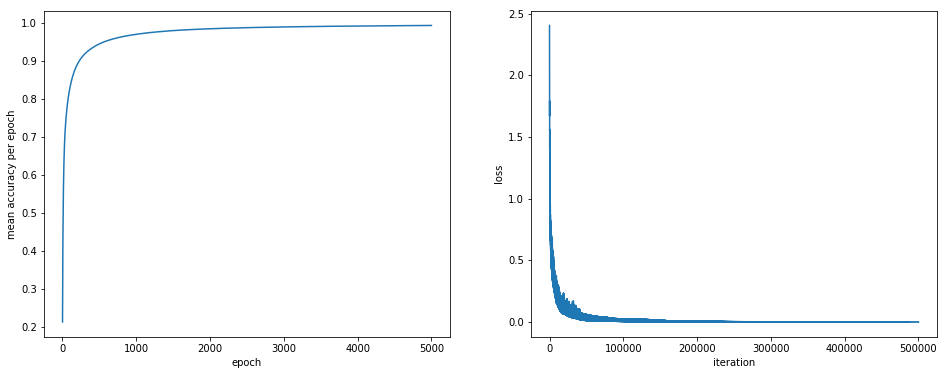

In [30]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(np.arange(1,epochs+1), train_acc_mean)
plt.ylabel('mean accuracy per epoch')
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(np.arange(1,global_iteration+1), loss_vec)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()

## Test the model on unseen examples (i.e. human readable dates)

In [31]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 
            'March 3 2001', 'March 3rd 2001', '1 March 2001', '21st of August 2016', 'August 21 2016',
            '3/27/70', '18.10.89','saturday september 29 1984', '8 01 16']

model = machine_translation_model(human_vocab_size=human_vocab_size, batch_size=1,
                       bi_lstm_size=bi_lstm_size, bi_lstm_layers=bi_lstm_layers, post_attention_lstm_size=post_attention_lstm_size,
                        post_attention_lstm_layers=post_attention_lstm_layers, learning_rate=learning_rate, Tx=Tx, Ty=Ty,
                                     test_mode=True)
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))

    
    test_bidirectional_state = sess.run(model.bidirectional_initial_state)
    test_post_attention_state_val = sess.run(model.post_attention_initial_state)
        
    for example in EXAMPLES:
        source = string_to_int(example, Tx, human_vocab)   
        x=np.array(source)
        x=x.reshape(1,-1)
    
        batches = get_batches(X[:1], Y[:1], 1)
        x1, y = next(batches)
    
        feed = {model.inputs_: x,
                   model.labels_: y,
                   model.bidirectional_initial_state: test_bidirectional_state,
                   model.post_attention_initial_state: test_post_attention_state_val}
            
            
        test_predictions_list, bidirectional_state,post_attention_state_val= sess.run([model.predictions_list,
                                                        model.bidirectional_final_state, 
                                                        model.post_attention_final_state],
                                feed_dict=feed)
        
        prediction = np.argmax(test_predictions_list, axis = -1)
        output = [inv_machine_vocab[int(i)] for i in prediction]
        print("source:", example)
        print("output:", ''.join(output))

W0816 10:24:52.760719 140400650716992 deprecation.py:323] From /home/vgkortsas/.conda/envs/TensorFlow_practice/lib/python3.5/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-04-05
source: 21th of August 2016
output: 2016-08-20
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-33
source: 1 March 2001
output: 2001-03-03
source: 21st of August 2016
output: 2016-08-00
source: August 21 2016
output: 2016-08-21
source: 3/27/70
output: 1970-03-27
source: 18.10.89
output: 1989-10-18
source: saturday september 29 1984
output: 1984-09-29
source: 8 01 16
output: 2016-11-08
